In [17]:
#some basic imports and setups
import os
import cv2
import math
import pandas as pd
import shutil
import glob
from random import shuffle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time


#mean of imagenet dataset in BGR (?)
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

#Need a folder with test images
current_dir = os.getcwd()
image_dir = os.path.join(current_dir, 'labeledYelp')

#need a csv with photo_id and labels for the test images
test_ground_truth_n = 'labeleddataset_n.csv'

#visulize after loading
num_visualize = 10
num_r = math.ceil(num_visualize/3)

#num of images stored when results agree and when they disagree 
num_vis = 20

#path to checckpoint
pth_ckpt = 'finetune_alexnet/yelp_ckpts/train_3l_20e/model_epoch20.ckpt'

%matplotlib inline

In [18]:
#get list of all images
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]

#load ground truth
samP = pd.read_csv(test_ground_truth_n)

photoIDs = samP['photo_id'].tolist()
labels   = samP['Label2'].tolist() 

print('                        size of test set: ' + str(len(imgs)))
print('new labeling. Num postitives in test set: ' + str(sum(labels)))
      
imgs = []
img_l_idx = []
for f in img_files:
    imgs.append(cv2.imread(f))
    imgn = (os.path.basename(f))
    #uncomment for accuracy
    filename, file_extension = os.path.splitext(imgn)
    img_l_idx.append(photoIDs.index(filename))


                        size of test set: 511
new labeling. Num postitives in test set: 308


In [19]:
from alexnet import AlexNet
from yelp_classes import class_names

tf.reset_default_graph() 

#placeholder for input and dropout rate
x = tf.placeholder(tf.float32, [1, 227, 227, 3])
keep_prob = tf.placeholder(tf.float32)

#create model with default config ( == no skip_layer and 1000 units in the last layer)
model = AlexNet(x, keep_prob, 2, [])

# Initialize an saver for store model checkpoints
saver = tf.train.Saver()

#define activation of last layer as score
score = model.fc8

#create op to calculate softmax 
softmax = tf.nn.softmax(score)

print(class_names)

['poor', 'good', '']


INFO:tensorflow:Restoring parameters from finetune_alexnet/yelp_ckpts/train_3l_20e/model_epoch20.ckpt
   Test Accuary:  0.8336594911937377
 Test Precision:  0.6455399061032864
    Test Recall:  1.0
Elapsed time: 45.542402267456055


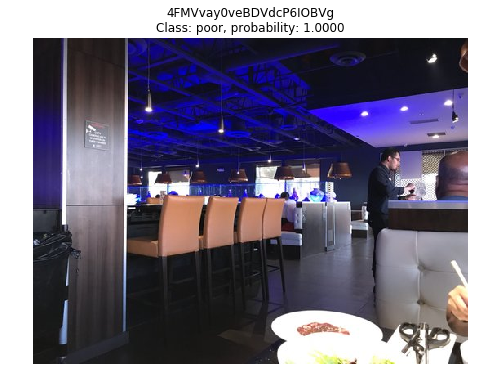

In [20]:
fig2 = plt.figure(figsize=(15,6))

start_time = time.time()

#counter for accuracy, precision
acc  = 0; tp   = 0; fp   = 0; fn   = 0

#counter for saving result pictures
vis_g_n = 0; vis_b_n = 0

with tf.Session() as sess:
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Load the pretrained weights into the model
    #model.load_initial_weights(sess)
    saver.restore(sess, pth_ckpt)
    
    count_b = 0  #counter for number of misclassified visulalized so far
    count_g = 0  #counter for number of corrcectly classified visulalized so far
    
    for i, image in enumerate(imgs):
        
        # Convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (227,227))
        
        # Subtract the ImageNet mean
        img -= imagenet_mean
        
        # Reshape as needed to feed into model
        img = img.reshape((1,227,227,3))
        
        # Run the session and calculate the class probability
        probs = sess.run(softmax, feed_dict={x: img, keep_prob: 1})
        
        # Get the class name of the class with the highest probability
        class_name = class_names[np.argmax(probs)]
        
        cls = 0
        if(class_name == 'good'):
            cls = 1
        
        ground_truth = labels[img_l_idx[i]]
        im_id        = photoIDs[img_l_idx[i]]
        
        if(cls == ground_truth):
            acc = acc+1;
            #Plot image with class name and prob in the title
            if(vis_g_n < num_vis):
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title(im_id + "\nClass: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)])
                plt.axis('off')
                count_g = count_g + 1
                fig_nm = './results/good_n/agree_' + str(vis_g_n) + '.png'
                plt.savefig(fig_nm)
                vis_g_n = vis_g_n + 1
        else:       
            #Plot image with class name and prob in the title
            if(vis_b_n < num_vis):
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title(im_id + "\nClass: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)])
                plt.axis('off')
                count_b = count_b + 1
                fig_nm = './results/bad_n/disagree_' + str(vis_b_n) + '.png'
                plt.savefig(fig_nm)
                vis_b_n = vis_b_n + 1
                
        if  (cls == 1 & ground_truth == 1): tp = tp+1
        elif(cls == 1 & ground_truth == 0): fp = fp+1
        elif(cls == 0 & ground_truth == 1): fn = fn+1
        

            
#label original
test_acc = acc/len(imgs)
test_pre = tp/(tp+fp)
test_rec = tp/(tp+fn)

print("   Test Accuary:  " + str(test_acc))
print(" Test Precision:  " + str(test_pre))
print("    Test Recall:  " + str(test_rec))

elapsed_time = time.time() - start_time

print("Elapsed time: " + str(elapsed_time))
    

    